# Data Engineering Capstone Project

#### Project Summary
In this capstone project, we will develop a data model designed to support OLAP queries analyzing immigration data ( US immigration data ).
In this data model, will included U.S immigration
, demographics as well as ports, countries, visa types data, etc...
We will be using Star Schema for the data model which is used for simpler & optimized queries.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [2]:
# Do all imports and installs here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from pyspark.sql.types import IntegerType, TimestampType
#from pyspark.sql.functions import udf,to_date
#from pyspark.sql.functions import isnan, when, count, col
import utilities
from utilities import plot_missing_values, columns_missing_values_90, check_duplicates, check_quality
from pyspark.sql.types import *
from pyspark.sql.functions import *

### Step 1: Scope the Project and Gather Data

#### Scope 


* In order to provide a wider base to study immigration data  to see movement of immigration in the U.S. along with additional information like visa type and from where these immigrants are coming , this project intends to enhance the U.S. I94 immigration data with additional data such as demographics, temperature data, etc.

* We'll carry out an extract, transform, and load (ETL) pipeline using Pyspark. The collected data will be cleansed and used to build the Star Schema in the data model as Apache Parquet columnar format ideal for OLAP queries because the data formats are inconsistent across all data sets, which is similar to an ETL from a data lake.


#### Describe and Gather Data 
* I94 Immigration Data: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. This is where the data comes from.
* World Temperature Data: This dataset came from Kaggle. You can read more about it here.
* U.S. City Demographic Data: This data comes from OpenSoft. You can read more about it here.
* Airport Code Table: This is a simple table of airport codes and corresponding cities. It comes from here.

## I94 Immigration Data

In [4]:
# Read in the data here
df_immigration = pd.read_csv("immigration_data_sample.csv")

In [37]:
df_immigration.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [39]:
df_immigration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
Unnamed: 0    1000 non-null int64
cicid         1000 non-null float64
i94yr         1000 non-null float64
i94mon        1000 non-null float64
i94cit        1000 non-null float64
i94res        1000 non-null float64
i94port       1000 non-null object
arrdate       1000 non-null float64
i94mode       1000 non-null float64
i94addr       941 non-null object
depdate       951 non-null float64
i94bir        1000 non-null float64
i94visa       1000 non-null float64
count         1000 non-null float64
dtadfile      1000 non-null int64
visapost      382 non-null object
occup         4 non-null object
entdepa       1000 non-null object
entdepd       954 non-null object
entdepu       0 non-null float64
matflag       954 non-null object
biryear       1000 non-null float64
dtaddto       1000 non-null object
gender        859 non-null object
insnum        35 non-null float64
airline       967 non

In [41]:
# check if there's any duplications
df_immigration.duplicated().value_counts()

False    1000
dtype: int64

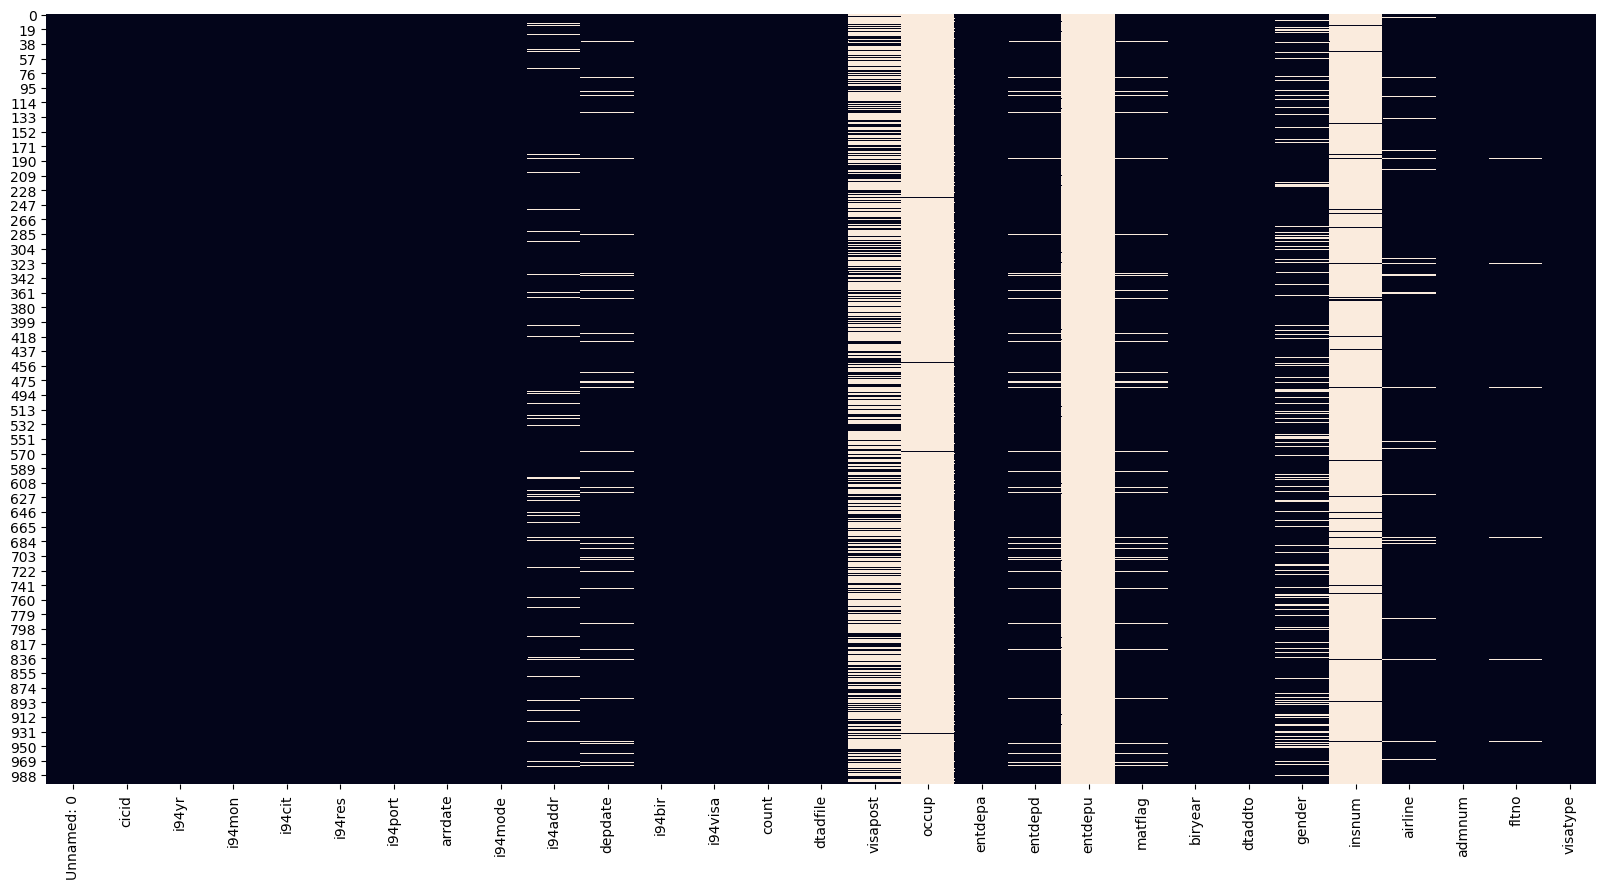

In [43]:
#checking if there's nan values in this dataset
plt.figure(figsize=(20,10))
sns.heatmap(df_immigration.isna(), cbar=False)

#### Read the immigration data using pandas or pyspark

In [7]:
# imm94_data = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
# df_imm94 = pd.read_sas(imm94_data, 'sas7bdat', encoding="ISO-8859-1")

In [8]:
# df_imm94.head(20)

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_imm94  = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [ ]:
# write to parquet
df_imm94.write.parquet("sas_data")

In [7]:
df_imm94=spark.read.parquet("sas_data")

In [49]:
df_imm94.show(2)

+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|5748517.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     CA|20582.0|  40.0|    1.0|  1.0|20160430|     SYD| null|      G|      O|   null|      M| 1976.0|10292016|     F|  null|     QF|9.495387003E10|00011|      B1|
|5748518.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     NV|20591.0|  32.0|    1.0|  

## World Temperatures Data By City

In [8]:
# temperatures = '../../data2/GlobalLandTemperaturesByCity.csv'
# df_temp = pd.read_csv(temperatures)
temperatures = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temp = spark.read.csv(temperatures, header=True, inferSchema=True)

In [53]:
@udf(returnType=StringType()) 
def get_state(str):
    return df_states.filter(col("name") == str.upper()).select("code").collect()[0].asDict().get('code')

In [55]:
#df_temp=df_temp.filter(df_temp["country"]=="United States")\
#.withColumn("year",year(df_temp["dt"]))\
#.withColumn("month",month(df_temp["dt"]))\
#.withColumn("state_abbrev", get_state(col("City")))

In [57]:
df_temp.show(10)

+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|                 dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01 00:00:00|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-04-01 00:00:00|5.7879999999999985|           3.6239999999999997|Århus|Denmark|  57.05N|   10.33E|
|1744-05-01 00:00:00|            10.644|           1.28300000000

In [59]:
df_temp.show(10)

+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|                 dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01 00:00:00|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-04-01 00:00:00|5.7879999999999985|           3.6239999999999997|Århus|Denmark|  57.05N|   10.33E|
|1744-05-01 00:00:00|            10.644|           1.28300000000

In [61]:
df_temp.describe().show()

+-------+------------------+-----------------------------+--------+-----------+--------+---------+
|summary|AverageTemperature|AverageTemperatureUncertainty|    City|    Country|Latitude|Longitude|
+-------+------------------+-----------------------------+--------+-----------+--------+---------+
|  count|           8235082|                      8235082| 8599212|    8599212| 8599212|  8599212|
|   mean|16.727432636250835|           1.0285747414536532|    null|       null|    null|     null|
| stddev|10.353442482534422|           1.1297332887133706|    null|       null|    null|     null|
|    min|-42.70399999999999|                        0.034|A Coruña|Afghanistan|   0.80N|    0.00W|
|    max|            39.651|           15.395999999999999|  Ürümqi|   Zimbabwe|   8.84S|   99.91E|
+-------+------------------+-----------------------------+--------+-----------+--------+---------+



In [63]:
# find all unique country names in temperatures data
df_temp.select('Country').distinct().collect()

[Row(Country='Chad'),
 Row(Country='Russia'),
 Row(Country='Paraguay'),
 Row(Country='Yemen'),
 Row(Country='Senegal'),
 Row(Country='Sweden'),
 Row(Country='Guyana'),
 Row(Country='Burma'),
 Row(Country='Philippines'),
 Row(Country='Eritrea'),
 Row(Country='Djibouti'),
 Row(Country='Malaysia'),
 Row(Country='Singapore'),
 Row(Country='Turkey'),
 Row(Country='Malawi'),
 Row(Country='Iraq'),
 Row(Country='Germany'),
 Row(Country='Afghanistan'),
 Row(Country='Cambodia'),
 Row(Country='Jordan'),
 Row(Country='Rwanda'),
 Row(Country='Sudan'),
 Row(Country='France'),
 Row(Country='Greece'),
 Row(Country='Sri Lanka'),
 Row(Country='Taiwan'),
 Row(Country='Algeria'),
 Row(Country='Equatorial Guinea'),
 Row(Country='Togo'),
 Row(Country='Slovakia'),
 Row(Country='Reunion'),
 Row(Country='Argentina'),
 Row(Country='Belgium'),
 Row(Country='Angola'),
 Row(Country='Ecuador'),
 Row(Country='Qatar'),
 Row(Country='Lesotho'),
 Row(Country='Madagascar'),
 Row(Country='Albania'),
 Row(Country='Finland

In [9]:
# extract all temperatures for united states
df_temp_usa = df_temp[df_temp["Country"] == "United States"]
df_temp_usa.show(10)

+-------------------+------------------+-----------------------------+-------+-------------+--------+---------+
|                 dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+-------------------+------------------+-----------------------------+-------+-------------+--------+---------+
|1820-01-01 00:00:00|2.1010000000000004|                        3.217|Abilene|United States|  32.95N|  100.53W|
|1820-02-01 00:00:00|             6.926|                        2.853|Abilene|United States|  32.95N|  100.53W|
|1820-03-01 00:00:00|            10.767|                        2.395|Abilene|United States|  32.95N|  100.53W|
|1820-04-01 00:00:00|17.988999999999994|                        2.202|Abilene|United States|  32.95N|  100.53W|
|1820-05-01 00:00:00|            21.809|                        2.036|Abilene|United States|  32.95N|  100.53W|
|1820-06-01 00:00:00|            25.682|                        2.008|Abilene|United States|  32.95N|  1

## U.S Cities Demographic Data

In [10]:
# df_demographic_usa = pd.read_csv("./us-cities-demographics.csv", delimiter=";")
# df_demographic_usa.head(20)
df_demographic_usa = spark.read.csv("./us-cities-demographics.csv", inferSchema=True, header=True, sep=';')
df_demographic_usa.show(5)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            City|        State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race|Count|
+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|   Silver Spring|     Maryland|      33.8|          40601|            41862|           82463|              1562|       30908|                   2.6|        MD|  Hispanic or Latino|25924|
|          Quincy|Massachusetts|      41.0|          44129|            49500|           93629|              4147|       32935|                  2.39|        MA|               White|58723|
|          Hoover|      Alabama|      38.5|          38040| 

In [69]:
df_demographic_usa.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



## Airport Codes Data

In [11]:
df_airport_codes = spark.read.csv("./airport-codes_csv.csv", header=True, inferSchema=True)
df_airport_codes.show(5)

+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|          11|       NA|         US|     US-PA|    Bensalem|     00A|     null|       00A|-74.9336013793945...|
| 00AA|small_airport|Aero B Ranch Airport|        3435|       NA|         US|     US-KS|       Leoti|    00AA|     null|      00AA|-101.473911, 38.7...|
| 00AK|small_airport|        Lowell Field|         450|       NA|         US|     US-AK|Anchor Point|    00AK|     null|      00AK|-151.695999146, 5...|
| 00AL|small_airport|        Epps Airpark|         820|       NA|         US|     

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

## Airport Codes Data

In [12]:
df_airport_codes.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [75]:
null_count_airports = df_airport_codes.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_airport_codes.columns])

In [77]:
null_count_airport = pd.DataFrame({'cols':null_count_airports.toPandas().columns.tolist(),'values':null_count_airports.toPandas().values[0].tolist()})

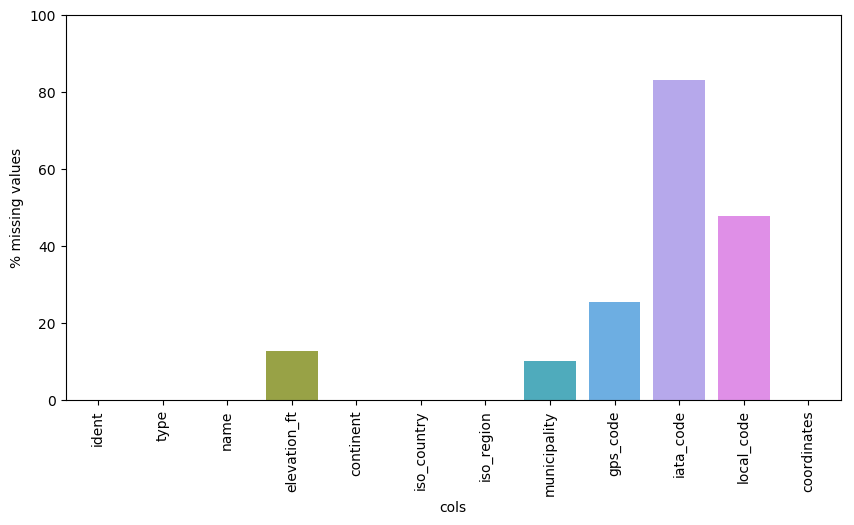

In [79]:
plot_missing_values(null_count_airport,df_airport_codes)

## I94 Immigration Data

In [81]:
df_imm94.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)



In [82]:
df_imm94.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,299.0,2016.0,4.0,103.0,103.0,NYC,20545.0,1.0,NY,20550.0,...,O,O,M,1962.0,06292016,None,OS,5.542587e+10,00087,WT
1,305.0,2016.0,4.0,103.0,103.0,NYC,20545.0,1.0,NY,20555.0,...,O,O,M,1953.0,06292016,None,OS,5.542582e+10,00087,WT
2,496.0,2016.0,4.0,103.0,103.0,CHI,20545.0,1.0,IL,20548.0,...,O,O,M,1952.0,06292016,None,OS,5.542862e+10,00065,WB
3,558.0,2016.0,4.0,103.0,103.0,SFR,20545.0,1.0,CA,20547.0,...,G,O,M,1974.0,06292016,M,LH,5.543331e+10,00454,WB
4,596.0,2016.0,4.0,103.0,103.0,NAS,20545.0,1.0,FL,20547.0,...,G,N,M,1992.0,06292016,M,UP,5.540611e+10,00221,WT


In [83]:
null_count = df_imm94.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_imm94.columns])

In [84]:
null_count = pd.DataFrame({'cols':null_count.toPandas().columns.tolist(),'values':null_count.toPandas().values[0].tolist()})

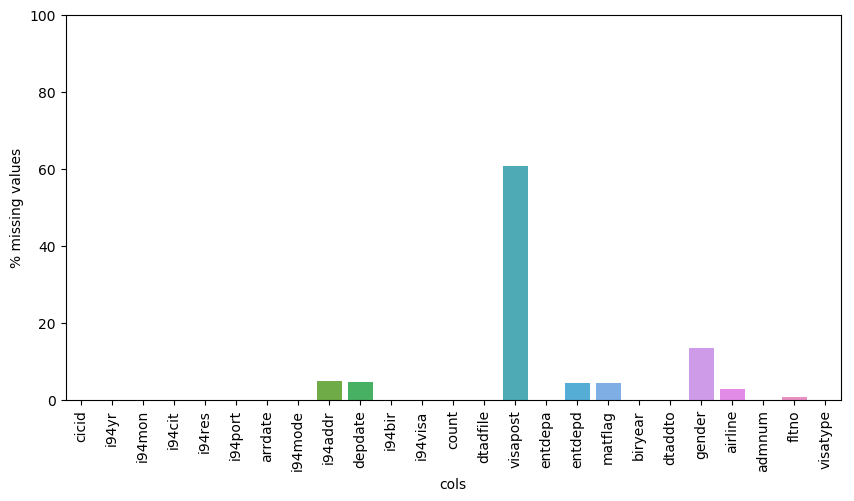

In [85]:
plot_missing_values(null_count,df_imm94)

## World Temperatures Data

In [86]:
df_temps = df_temp_usa.withColumn("dt",col("dt").cast(StringType()))

In [87]:
null_count_temp = df_temps.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_temps.columns])

In [88]:
null_count_temp  = pd.DataFrame({'cols':null_count_temp.toPandas().columns.tolist(),'values':null_count_temp.toPandas().values[0].tolist()})

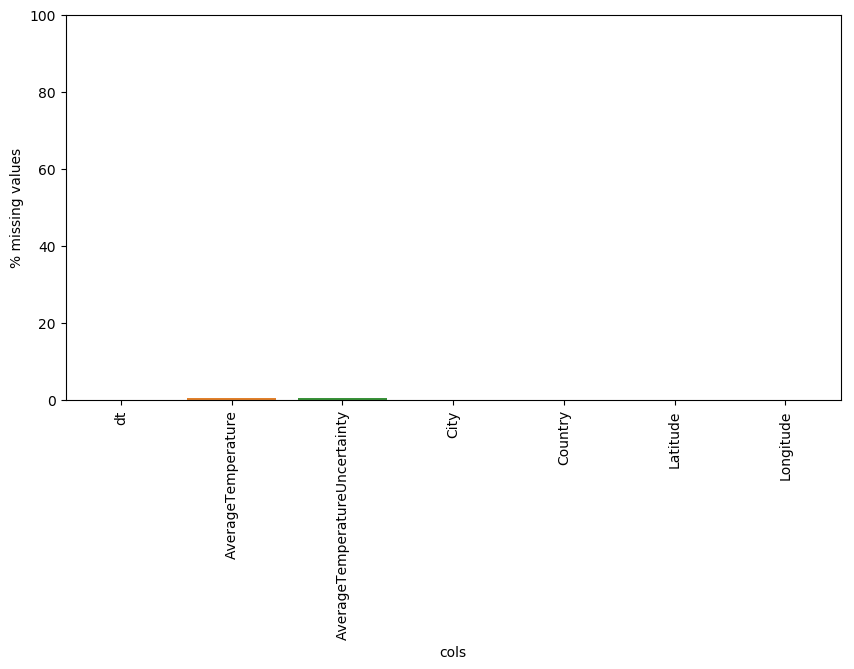

In [89]:
plot_missing_values(null_count_temp,df_temp)

## U.S Cities Demographic Data

In [90]:
df_demographic_usa.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: integer (nullable = true)
 |-- female_population: integer (nullable = true)
 |-- number_of_veterans: integer (nullable = true)
 |-- foreign_born: integer (nullable = true)
 |-- average_household_size: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- count: integer (nullable = true)



In [91]:
null_count_demographic = df_demographic_usa.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_demographic_usa.columns])

In [92]:
null_count_demographic  = pd.DataFrame({'cols':null_count_demographic.toPandas().columns.tolist(),'values':null_count_demographic.toPandas().values[0].tolist()})

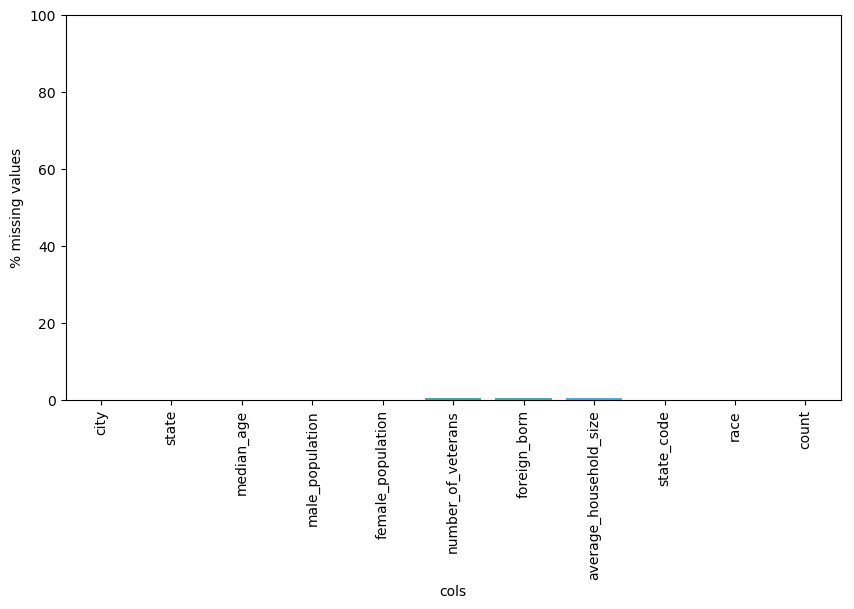

In [93]:
plot_missing_values(null_count_demographic,df_demographic_usa)

## Cleaning Steps
steps necessary to clean the data

## I94 Immigration Data

#### Convert arrive_date, departure_date in immigration data to pandad datetime format instead of SAS format 

In [94]:
df_imm94.select('arrdate').take(5)

[Row(arrdate=20574.0),
 Row(arrdate=20574.0),
 Row(arrdate=20574.0),
 Row(arrdate=20574.0),
 Row(arrdate=20574.0)]

In [95]:
toInt = udf(lambda x: int(x) if x!=None else x, IntegerType())

for colname, coltype in df_imm94.dtypes:
    if coltype == 'double':
        df_imm94 = df_imm94.withColumn(colname, toInt(colname))

In [96]:
@udf(returnType=TimestampType())
def to_timestamp_udf(x):
    try:
        return pd.to_timedelta(x, unit='D') + pd.Timestamp('1960-1-1')
    except:
        return pd.Timestamp('1900-1-1')

df_imm94 = df_imm94.withColumn('arrdate', to_date(to_timestamp_udf(col('arrdate'))))\
               .withColumn('depdate', to_date(to_timestamp_udf(col('depdate'))))


In [97]:
df_imm94.select('arrdate').take(5)

[Row(arrdate=datetime.date(2016, 4, 30)),
 Row(arrdate=datetime.date(2016, 4, 30)),
 Row(arrdate=datetime.date(2016, 4, 30)),
 Row(arrdate=datetime.date(2016, 4, 30)),
 Row(arrdate=datetime.date(2016, 4, 30))]

In [98]:
df_imm94.count()

3096313

#### Drop all columns with 90% ore more missing values.

In [99]:
columns_missing_values_90(null_count,df_imm94)

[]

In [100]:
df_imm94 = df_imm94.drop(*columns_missing_values_90(null_count,df_imm94))

In [101]:
df_imm94.columns

['cicid',
 'i94yr',
 'i94mon',
 'i94cit',
 'i94res',
 'i94port',
 'arrdate',
 'i94mode',
 'i94addr',
 'depdate',
 'i94bir',
 'i94visa',
 'count',
 'dtadfile',
 'visapost',
 'entdepa',
 'entdepd',
 'matflag',
 'biryear',
 'dtaddto',
 'gender',
 'airline',
 'admnum',
 'fltno',
 'visatype']

In [102]:
df_imm94.count()

3096313

#### Drop duplicate rows

In [103]:
df_imm94 = df_imm94.dropDuplicates(['cicid'])

In [104]:
df_imm94.show(10)

+-----+-----+------+------+------+-------+----------+-------+-------+----------+------+-------+-----+--------+--------+-------+-------+-------+-------+--------+------+-------+----------+-----+--------+
|cicid|i94yr|i94mon|i94cit|i94res|i94port|   arrdate|i94mode|i94addr|   depdate|i94bir|i94visa|count|dtadfile|visapost|entdepa|entdepd|matflag|biryear| dtaddto|gender|airline|    admnum|fltno|visatype|
+-----+-----+------+------+------+-------+----------+-------+-------+----------+------+-------+-----+--------+--------+-------+-------+-------+-------+--------+------+-------+----------+-----+--------+
|  148| 2016|     4|   103|   103|    NEW|2016-04-01|      1|     NY|2016-04-08|    21|      2|    1|20160401|    null|      G|      O|      M|   1995|06292016|     F|     OS|-412600015|00089|      WT|
|  463| 2016|     4|   103|   103|    MIA|2016-04-01|      1|     FL|2016-04-02|    25|      2|    1|20160401|    null|      O|      R|      M|   1991|06292016|  null|     OS|-405559115|00097|

## World Temperatures Data 

#### Get list of columns that has 90% or more of missing values

In [105]:
columns_missing_values_90(null_count_temp,df_temp)

[]

#### Drop rows with missing average temperature


In [106]:
df_temp = df_temp.dropna(subset=['AverageTemperature'])

#### drop duplicate rows

In [107]:
df_temp = df_temp.drop_duplicates(subset=['dt', 'City', 'Country'])

## U.S Cities Demographic Data

#### get list of columns that has 90% or more of missing values

In [108]:
columns_missing_values_90(null_count_demographic,df_demographic_usa)

[]

In [109]:
df_demographic_usa.count()

2891

In [110]:
df_demographic_usa.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: integer (nullable = true)
 |-- female_population: integer (nullable = true)
 |-- number_of_veterans: integer (nullable = true)
 |-- foreign_born: integer (nullable = true)
 |-- average_household_size: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- count: integer (nullable = true)



In [ ]:
df_demographic_usa.printSchema()

#### Drop duplicate rows

In [115]:
#df_demographic_usa = df_demographic_usa.dropDuplicates(subset=['City', 'State', 'State Code', 'Race'])

In [ ]:
df_demographic_usa.count()

In [4]:
def sas_labels_descriptions_data(input_label):

    with open('I94_SAS_Labels_Descriptions.SAS') as labels_descriptions:
            rawlabels_data = labels_descriptions.read()

    labels_data = rawlabels_data[rawlabels_data.index(input_label):]
    labels_data = labels_data[:labels_data.index(';')]
    
    
    lines = labels_data.splitlines()
    values_list = []
    for line in lines:
        try:
            codes, values = line.split('=')
            codes = codes.strip().strip("'").strip('"')
            values = values.strip().strip("'").strip('"').strip()
            values_list.append((codes, values))
        except:
            pass
        
    return values_list

In [5]:
# define schema that will be used for all labels
schema = StructType ([
        StructField ("code", StringType ()),
        StructField ("name", StringType ())
    ])

In [6]:
df_countries = spark.createDataFrame(
        data=sas_labels_descriptions_data('I94RES'),
        schema=schema
)

In [7]:
df_countries.show()

+----+--------------------+
|code|                name|
+----+--------------------+
| 582|MEXICO Air Sea, a...|
| 236|         AFGHANISTAN|
| 101|             ALBANIA|
| 316|             ALGERIA|
| 102|             ANDORRA|
| 324|              ANGOLA|
| 529|            ANGUILLA|
| 518|     ANTIGUA-BARBUDA|
| 687|           ARGENTINA|
| 151|             ARMENIA|
| 532|               ARUBA|
| 438|           AUSTRALIA|
| 103|             AUSTRIA|
| 152|          AZERBAIJAN|
| 512|             BAHAMAS|
| 298|             BAHRAIN|
| 274|          BANGLADESH|
| 513|            BARBADOS|
| 104|             BELGIUM|
| 581|              BELIZE|
+----+--------------------+
only showing top 20 rows



In [8]:
df_ports = spark.createDataFrame(
        data=sas_labels_descriptions_data('I94PORT'),
        schema=schema
)

In [9]:
df_ports.show()

+----+--------------------+
|code|                name|
+----+--------------------+
| ALC|           ALCAN, AK|
| ANC|       ANCHORAGE, AK|
| BAR|BAKER AAF - BAKER...|
| DAC|   DALTONS CACHE, AK|
| PIZ|DEW STATION PT LA...|
| DTH|    DUTCH HARBOR, AK|
| EGL|           EAGLE, AK|
| FRB|       FAIRBANKS, AK|
| HOM|           HOMER, AK|
| HYD|           HYDER, AK|
| JUN|          JUNEAU, AK|
| 5KE|       KETCHIKAN, AK|
| KET|       KETCHIKAN, AK|
| MOS|MOSES POINT INTER...|
| NIK|         NIKISKI, AK|
| NOM|             NOM, AK|
| PKC|     POKER CREEK, AK|
| ORI|  PORT LIONS SPB, AK|
| SKA|         SKAGWAY, AK|
| SNP| ST. PAUL ISLAND, AK|
+----+--------------------+
only showing top 20 rows



In [10]:
df_states = spark.createDataFrame(
        data=sas_labels_descriptions_data('I94ADDR'),
        schema=schema
)

In [11]:
df_states.show()

+----+-----------------+
|code|             name|
+----+-----------------+
|  AL|          ALABAMA|
|  AK|           ALASKA|
|  AZ|          ARIZONA|
|  AR|         ARKANSAS|
|  CA|       CALIFORNIA|
|  CO|         COLORADO|
|  CT|      CONNECTICUT|
|  DE|         DELAWARE|
|  DC|DIST. OF COLUMBIA|
|  FL|          FLORIDA|
|  GA|          GEORGIA|
|  GU|             GUAM|
|  HI|           HAWAII|
|  ID|            IDAHO|
|  IL|         ILLINOIS|
|  IN|          INDIANA|
|  IA|             IOWA|
|  KS|           KANSAS|
|  KY|         KENTUCKY|
|  LA|        LOUISIANA|
+----+-----------------+
only showing top 20 rows



In [12]:
df_travel_modes = spark.createDataFrame(
        data=sas_labels_descriptions_data('I94MODE'),
        schema=schema
)


In [13]:
df_travel_modes.show()

+----+------------+
|code|        name|
+----+------------+
|   1|         Air|
|   2|         Sea|
|   3|        Land|
|   9|Not reported|
+----+------------+



In [14]:
df_visa_categories = spark.createDataFrame(
        data=sas_labels_descriptions_data('I94VISA'),
        schema=schema
)

In [15]:
df_visa_categories.show()

+----+--------+
|code|    name|
+----+--------+
|   1|Business|
|   2|Pleasure|
|   3| Student|
+----+--------+



In [16]:
check_duplicates(df_countries)

False

### Step 3: Define the Data Model
#### Conceptual Data Model & Mapping Out Data Pipelines
OLAP queries were considered when creating the star schema. The ETL procedure made sure that the dimension tables are normalized, followed by the data quality tests. The joins are also simple and less expensive on the database because the dimension tables are reasonably small and have a sufficient number of unique primary keys.




<code>i94_fact_table</code>


- **cicid:** id
- **entry_year:** year
- **state_code:** immigrant state code
- **entry_month:**  month
- **origin_country_code:** i94 country code as per SAS Labels Descriptions file
- **port_code:** i94port code as per SAS Labels Descriptions file
- **visa_type:** visa type
- **flight_number:** flight number
- **arrival_date:** date of arrival in U.S.
- **travel_mode_code:** code for travel mode of arrival as per SAS Labels Descriptions file
- **us_state_code:** two letter U.S. state code
- **departure_date:** departure date from U.S.
- **age:** immigrant age 
- **visa_category_code:** visa category code as per SAS Labels Descriptions file
- **occupation:** immigrant occupation 
- **gender:** immigrant gender
- **birth_year:**immigrant birth year 
- **entry_date:** date to which admitted to U.S
- **airline:** airline code used to arrive in U.S
- **admission_number:** admission number

<code>df_airport_codes</code>
- **ident:** string - Airport id
- **type:** string - size of airport
- **name:** string - name
- **elevation_ft**: float - elevation in feet
- **continent:** string - continet
- **iso_country:** string  - country (ISO-2)
- **iso_region:** string  - region (ISO-2)
- **municipality:** string - municipality
- **gps_code:** string  - gps code
- **iata_code:** string  - IATA code
- **local_code:** string - Local code
- **coordinates:** string - coordinates


<code>visa_categories_dim_table (df_visa_categories) </code>

- **code:** string  - visa code
- **name:** string  - visa description

<code>travel_modes_dim_table (df_travel_modes) </code>
- **code:** string  - Mode code
- **name:** string  - Mode description

<code>states_dim_table (df_states) </code>
- **code:** string  - state code
- **name:** string  - state description





* We will be using join to match keys and create foreign keys to help us create a conenction between our fact table i94_stg and dimensions 
like countries_stg, ports_stg, states_stg,visa_categories_stg, travel_modes_stg, us_demographics_stg and airport_codes_stg.
i94_fact_table = spark.sql("""
            SELECT
                sid.cicid AS cicid,
                sid.i94yr AS entry_year,
                sid.i94addr as state_code,
                sid.i94mon AS entry_month,
                cs.code AS origin_country_code, #foreign key between fact table and countries_stg
                ps.code AS port_code, #foreign key between fact table and ports_stg
                sid.visatype AS visa_type,
                sid.fltno AS flight_number,
                sid.arrdate AS arrival_date,
                tms.code AS travel_mode_code, #foreign key between fact table and travel_modes_stg
                stsg.code AS us_state_code, #foreign key between fact table and states_stg
                sid.depdate AS departure_date,
                sid.i94bir AS age,
                vcs.code AS visa_category_code, #foreign key between fact table and visa_categories_stg
                sid.gender AS gender,
                sid.biryear AS birth_year,
                sid.dtaddto AS entry_date,
                sid.airline AS airline,
                sid.admnum AS admission_number
                
            FROM i94_stg sid
                JOIN countries_stg cs ON cs.code = sid.i94res
                JOIN ports_stg ps ON ps.code = sid.i94port
                JOIN states_stg stsg ON stsg.code = sid.i94addr
                JOIN visa_categories_stg vcs ON vcs.code = sid.i94visa
                JOIN travel_modes_stg tms ON tms.code = sid.i94mode
                
            WHERE 
                cs.code IS NOT NULL AND
                ps.code IS NOT NULL AND
                stsg.code IS NOT NULL AND
                tms.code IS NOT NULL AND
                vcs.code IS NOT NULL
        """)

## Foreign keys 

* origin_country_code, #foreign key between fact table and countries_stg
* port_code, #foreign key between fact table and ports_stg
* travel_mode_code, #foreign key between fact table and travel_modes_stg
* stsg.code AS us_state_code, #foreign key between fact table and states_stg
* vcs.code AS visa_category_code, #foreign key between fact table and visa_categories_stg

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [16]:
# Staging tables
df_imm94.createOrReplaceTempView('i94_stg')
#df_airport_codes.createOrReplaceTempView('airport_codes_stg')
#df_demographic_usa.createOrReplaceTempView('us_demographics_stg')
df_states.createOrReplaceTempView('states_stg')
df_visa_categories.createOrReplaceTempView('visa_categories_stg')
df_travel_modes.createOrReplaceTempView('travel_modes_stg')
df_ports.createOrReplaceTempView('ports_stg')
df_countries.createOrReplaceTempView('countries_stg')

In [131]:
df_temp.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [136]:
df_imm94.printSchema()

root
 |-- cicid: integer (nullable = true)
 |-- i94yr: integer (nullable = true)
 |-- i94mon: integer (nullable = true)
 |-- i94cit: integer (nullable = true)
 |-- i94res: integer (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: date (nullable = true)
 |-- i94mode: integer (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: date (nullable = true)
 |-- i94bir: integer (nullable = true)
 |-- i94visa: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: integer (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: integer (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)



In [17]:
i94_fact_table = spark.sql("""
            SELECT
                sid.cicid AS cicid,
                sid.i94yr AS entry_year,
                sid.i94addr as state_code,
                sid.i94mon AS entry_month,
                cs.code AS origin_country_code,
                ps.code AS port_code,
                sid.visatype AS visa_type,
                sid.fltno AS flight_number,
                sid.arrdate AS arrival_date,
                tms.code AS travel_mode_code,
                stsg.code AS us_state_code,
                sid.depdate AS departure_date,
                sid.i94bir AS age,
                vcs.code AS visa_category_code,
                sid.gender AS gender,
                sid.biryear AS birth_year,
                sid.dtaddto AS entry_date,
                sid.airline AS airline,
                sid.admnum AS admission_number
                
            FROM i94_stg sid
                left JOIN countries_stg cs ON cs.code = sid.i94res
                left JOIN ports_stg ps ON ps.code = sid.i94port
                left JOIN states_stg stsg ON stsg.code = sid.i94addr
                left JOIN visa_categories_stg vcs ON vcs.code = sid.i94visa
                left JOIN travel_modes_stg tms ON tms.code = sid.i94mode
                
            WHERE 
                cs.code IS NOT NULL AND
                ps.code IS NOT NULL AND
                stsg.code IS NOT NULL AND
                tms.code IS NOT NULL AND
                vcs.code IS NOT NULL
        """)

In [18]:
i94_fact_table.limit(5).toPandas()

,cicid,entry_year,state_code,entry_month,origin_country_code,port_code,visa_type,flight_number,arrival_date,travel_mode_code,us_state_code,departure_date,age,visa_category_code,gender,birth_year,entry_date,airline,admission_number
0,3386206.0,2016.0,AZ,4.0,438,FMY,WB,00093,20562.0,1,AZ,20568.0,54.0,1,M,1962.0,07162016,QF,5.635993e+10
1,1393063.0,2016.0,CA,4.0,201,LOS,B2,00012,20552.0,1,CA,20566.0,40.0,2,M,1976.0,10072016,BR,9.306166e+10
2,3381198.0,2016.0,AZ,4.0,268,FMY,WB,00006,20562.0,1,AZ,20567.0,37.0,1,M,1979.0,07162016,CI,5.639123e+10
3,4842948.0,2016.0,FL,4.0,689,FTL,B2,08704,20569.0,1,FL,20574.0,30.0,2,F,1986.0,10242016,AD,9.447752e+10
4,803901.0,2016.0,AZ,4.0,689,FMY,B1,00216,20548.0,1,AZ,20552.0,55.0,1,M,1961.0,10032016,AA,9.271847e+10


In [29]:
i94_fact_table.createOrReplaceTempView('i94_fact_table')

In [ ]:
### immigrant_per_visa_type
spark.sql("""
SELECT count(cicid),visa_type
FROM i94_fact_table as immg
group by visa_type
""").show()


In [20]:
# dim tables saved as parquet files 
# imm94_facttable = spark.read.parquet("i94_fact_table")
# city_dim_table = spark.read.parquet("city_dim_table")
# ports_dim_table = spark.read.parquet("ports_dim_table")
# states_dim_table = spark.read.parquet("states_dim_table")
# countries_dim_table = spark.read.parquet("countries_dim_table")
# travel_modes_dim_table = spark.read.parquet("travel_modes_dim_table")
# visa_categories_dim_table = spark.read.parquet("visa_categories_dim_table")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [21]:
check_duplicates(df_countries)

False

In [22]:
# Perform quality checks here
spark.sql("""
    SELECT 
        COUNT(*) as count
    FROM travel_modes_stg
""").show()

+-----+
|count|
+-----+
|    4|
+-----+



In [23]:
check_quality(df_imm94,'df_imm94')

Data quality check passed for this dataframe df_imm94 with 3096313 records


In [24]:
check_quality(df_states,'states_stg')

Data quality check passed for this dataframe states_stg with 55 records


In [25]:
check_quality(df_visa_categories,'df_visa_categories')

Data quality check passed for this dataframe df_visa_categories with 3 records


In [26]:
check_quality(df_travel_modes,'df_travel_modes')

Data quality check passed for this dataframe df_travel_modes with 4 records


In [27]:
check_quality(df_ports,'df_ports')

Data quality check passed for this dataframe df_ports with 660 records


In [28]:
check_quality(df_countries,'df_countries')

Data quality check passed for this dataframe df_countries with 289 records


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* I useed Apache spark here because of the following points: 
    * it's ability to process large-scale data.
    * A lightning-fast unified analytics engine for big data.
    
* Propose how often the data should be updated and why:
    * Data should be updated monthly. This will give us the most up-to-date data.

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x:
 
   * We might consider increasing the number of work nodes in our cluster.
   
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
     * We can use Apache Airflow to orchestrate and schedule data pipelines.
     
 * The database needed to be accessed by 100+ people:
 
    * we can opt to use Redshift to have the data stored in a way that it can efficiently be accessed by many people.